In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='6'

import tensorflow as tf
from tensorflow.keras import layers, optimizers, models, datasets, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics as sk_metrics
from sklearn.model_selection import train_test_split

import scipy

from datetime import datetime

import PIL
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
dataset_path = "/local/sandbox/DIODE_dataset/"

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
def ds_args(image):
    image = np.log(image)
    if image.shape[-1] == 1:
        image = np.squeeze(image, axis=-1)
    return image, {
        "cmap": "jet", # turbo doesn't exist in mpl 2.2.3
        "vmin": 0,
        "vmax": 3,
    }
    
def depthshow(image):
    args = ds_args(image)
    plt.imshow(args[0], **args[1])
    plt.axis("off")
    plt.show()

def imgrid(data, is_grid=False):
    print(data.shape)
    if not is_grid and data.shape[0] % 10 == 0:
        data = np.reshape(data, (-1, 10, *data.shape[1:]))
    if data.shape[-1] == 1:
        data = np.reshape(data, data.shape[:-1])
    print(data.shape)
    fig, ax = plt.subplots(data.shape[0], data.shape[1])
    fig.set_size_inches(data.shape[1], data.shape[0])
    for y in range(data.shape[0]):
        for x in range(data.shape[1]):
            if data.shape[0] == 1:
                args = ds_args(data[y, x])
                ax[x].imshow(args[0], **args[1])
                ax[x].set_axis_off()
            else:
                args = ds_args(data[y, x])
                ax[y][x].imshow(args[0], **args[1])
                ax[y][x].set_axis_off()
    plt.show()
    
def display_images(rgb, pred, depth):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(4, 1)
    for i in range(3):
        ax[i].set_axis_off()
    ax[0].imshow(rgb)
    
    with np.errstate(divide='ignore'):
        args = ds_args(pred)
        ax[1].imshow(args[0], **args[1])

        args = ds_args(depth)
        ax[2].imshow(args[0], **args[1])
    plt.show()

In [4]:
all_data = np.load(dataset_path + "DIODE_dataset.npz")

# TODO: use outdoor or both
train_rgb = all_data["train_indoors_rgb"] / 255
train_depth = all_data["train_indoors_depth"]
train_depth_mask = all_data["train_indoors_depth_mask"].astype(int)
train_depth_mask = np.expand_dims(train_depth_mask, -1)
val_rgb = all_data["val_indoors_rgb"] / 255
val_depth = all_data["val_indoors_depth"]
val_depth_mask = all_data["val_indoors_depth_mask"].astype(int)
val_depth_mask = np.expand_dims(val_depth_mask, -1)

In [37]:
def interp_depths(depth, depth_mask):
    full_depth = np.zeros_like(depth)
    depth_mask_scan = np.zeros_like(depth_mask)
    
    middle = depth.shape[1] // 2
    depth = depth[:, middle, :, 0]
    depth_mask = depth_mask[:, middle, :, 0]
    depth_mask_scan[:, middle, :, 0] = depth_mask
    
    for i in range(depth.shape[0]):
        indices = np.arange(depth.shape[1])
        masked_depth = depth[i, depth_mask[i].astype(bool)]
        masked_indices = indices[depth_mask[i].astype(bool)]
        
        full_depth_fn = scipy.interpolate.interp1d(masked_indices, masked_depth, kind="linear", fill_value="extrapolate", assume_sorted=True)
        interp_scan = full_depth_fn(indices)
        interp_scan = (interp_scan > 0) * interp_scan
        full_depth[i, :, :, 0] = np.repeat(np.expand_dims(interp_scan, 0), full_depth.shape[1], axis=0)
    
    return full_depth, depth_mask_scan

In [38]:
train_depth_scan, train_depth_mask_scan = interp_depths(train_depth, train_depth_mask)
val_depth_scan, val_depth_mask_scan = interp_depths(val_depth, val_depth_mask)

In [7]:
print(len(train_rgb), "train samples,", len(val_rgb), "val samples")
print(train_rgb[0].shape)
print(train_depth[0].shape)
print(train_depth_mask[0].shape)
image_shape = train_rgb[0].shape

train_gen = ImageDataGenerator().flow((train_rgb, [train_depth_scan, train_depth_mask_scan, train_depth, train_depth_mask]), train_depth, batch_size=16, shuffle=True)
val_gen = ImageDataGenerator().flow((val_rgb, [val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask]), val_depth, batch_size=16, shuffle=False)

8574 train samples, 325 val samples
(192, 256, 3)
(192, 256, 1)
(192, 256, 1)


In [8]:
reg = regularizers.l2(1e-5)

def conv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2D(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

def tconv_block(filters, strides=1, padding='same', sd=0.1):
    return [
        layers.Conv2DTranspose(filters, kernel_size=3, strides=strides, padding=padding, kernel_regularizer=reg, activity_regularizer=reg),
        layers.ReLU(),
        layers.SpatialDropout2D(sd),
        #layers.BatchNormalization(renorm=True),
    ]

In [ ]:
def make_model():
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = layers.Concatenate()([rgb_in, depth_scan_in])
    
    depth_downscale_blocks = [
        [*conv_block(4)],
        [*conv_block(4, 2)],
        [*conv_block(8, 2)],
        [*conv_block(8, 2)],
        [*conv_block(16, 2)],
        [*conv_block(16, 2)],
    ]
    
    downscale_blocks = [
        [*conv_block(4),
         *conv_block(4)],
        [*conv_block(8, 2),
         *conv_block(8)],
        [*conv_block(16, 2),
         *conv_block(16)],
        [*conv_block(32, 2),
         *conv_block(32)],
        [*conv_block(64, 2),
         *conv_block(64)],
        [*conv_block(128, 2),
         *conv_block(128)],
    ]
    
    middle_blocks = [
        *conv_block(128, 2),
        *conv_block(128),
        *conv_block(128),
        *tconv_block(128, 2)
    ]
    
    upscale_blocks = [
        middle_blocks,
        [*conv_block(128),
         *tconv_block(64, 2)],
        [*conv_block(64),
         *tconv_block(32, 2)],
        [*conv_block(32),
         *tconv_block(16, 2)],
        [*conv_block(16),
         *tconv_block(8, 2)],
        [*conv_block(8),
         *tconv_block(4, 2)],
        [*conv_block(4)],
    ]
        
    downscale_x_depths = [x_depths]
    for block in depth_downscale_blocks:
        x_depths = models.Sequential(block)(downscale_x_depths[-1])
        downscale_x_depths += [x_depths]
    
    downscale_xs = [x]
    for blocks, downscale_x_depth in zip(downscale_blocks, downscale_x_depths):
        x = layers.Concatenate()([x, downscale_x_depth])
        x = models.Sequential(blocks)(downscale_xs[-1])
        downscale_xs += [x]
    
    for blocks, downscale_x, downscale_x_depth in zip(upscale_blocks, reversed(downscale_xs), reversed(downscale_x_depths)):
        x = models.Sequential(blocks)(x)
        x = layers.Concatenate()([x, downscale_x, downscale_x_depth])
    
    final_layers = models.Sequential([
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-3)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log(y_true + 1) - tf.math.log(y_pred + 1)) * depth_mask_in))
    metrics = []

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [9]:
def make_resnet_model():
    
    rgb_in = layers.Input(image_shape)
    depth_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_in = layers.Input(image_shape[:2] + (1,))
    depth_scan_in = layers.Input(image_shape[:2] + (1,))
    depth_mask_scan_in = layers.Input(image_shape[:2] + (1,))
    
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=image_shape, input_tensor=rgb_in)
    #resnet.summary()
    
    # x_depths = layers.Concatenate()([depth_scan_in, depth_mask_scan_in])
    x = rgb_in
    
    depth_downscale_blocks = [
        [*conv_block(4), *conv_block(4, 2)], # 128
        [*conv_block(8, 2)], # 64
        [*conv_block(16, 2)], # 32
        [*conv_block(32, 2)], # 16
        [*conv_block(64, 2)], # 8
    ]
    
    upscale_blocks = [
        [*conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *conv_block(512),
         *tconv_block(512, 2)], # 16
        [*tconv_block(256, 2)], # 32
        [*tconv_block(128, 2)], # 64
        [*tconv_block(64, 2)], # 128
        [*tconv_block(32, 2)], # 256
    ]
    
    downscale_xs = [rgb_in] + [resnet.layers[i].output for i in [4, 38, 80, 142]]
    # [256, 128, 64, 32, 16]
        
    # downscale_x_depths = []
    # for block in depth_downscale_blocks:
    #     downscale_x_depths += [x_depths]
    #     x_depths = models.Sequential(block)(downscale_x_depths[-1])
        
    x = resnet(x)
    # x = layers.Concatenate()([x, x_depths])
    
    for up_blocks, downscale_x in zip(upscale_blocks, reversed(downscale_xs)):
        x = models.Sequential(up_blocks)(x)
        x = layers.Concatenate()([x, downscale_x])
    
    final_layers = models.Sequential([
        *conv_block(16),
        *conv_block(4),
        layers.Conv2D(1, kernel_size=3, padding="same"),
        layers.ReLU(),
    ])
    
    depth_preds = final_layers(x)
    
    model = models.Model([rgb_in, depth_scan_in, depth_mask_scan_in, depth_in, depth_mask_in], [depth_preds])
    #model.summary()
    
    opt = optimizers.Adam(learning_rate=1e-4)
    loss = lambda y_true, y_pred: tf.math.reduce_mean(tf.math.square((tf.math.log1p(y_true) - tf.math.log1p(y_pred)) * depth_mask_in))
    
    ln_log10 = 2.3025 # ln(10) for conversion from ln to log10
    masked_depth_in = depth_in * depth_mask_in
    masked_depth_pred = depth_preds * depth_mask_in
    def mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs(masked_depth_in - masked_depth_pred))
    def rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(masked_depth_in - masked_depth_pred)))
    def abs_rel(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.divide_no_nan(tf.math.abs(masked_depth_in - masked_depth_pred), masked_depth_in))
    def log10_mae(y_true, y_pred):
        return tf.math.reduce_mean(tf.math.abs((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10)))
    def log10_rmse(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((tf.math.log1p(masked_depth_in) / ln_log10) - (tf.math.log1p(masked_depth_pred) / ln_log10))))
    metrics = [mae, rmse, abs_rel, log10_mae, log10_rmse]

    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [10]:
tf.keras.backend.clear_session()

In [11]:
model = make_resnet_model()

In [12]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "-est-resnet"

class DisplayCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = 100
        sample = model.predict([[val_rgb[i]], [val_depth_scan[i]], [val_depth_mask_scan[i]], [val_depth[i]], [val_depth_mask[i]]])
        display_images(val_rgb[i], sample[0], val_depth[i] * val_depth_mask[i])

tensorboard_cb = callbacks.TensorBoard(log_dir="./logs/" + run_name)

curr_epochs = 0

In [13]:
def run_epochs(epochs=100, lr_epoch=100):
    global curr_epochs
    cb = [
        callbacks.LearningRateScheduler(lambda e, l: l if (e + 1) % lr_epoch != 0 else l / 3, verbose=1),
        DisplayCallback(),
        tensorboard_cb,
    ]

    history = model.fit(
        train_gen,
        epochs=(epochs + curr_epochs),
        initial_epoch=curr_epochs,
        validation_data=val_gen,
        callbacks=cb,
    )
    
    curr_epochs += epochs
    return history

def display_samples(indices=[0, 100, 200, 300]):
    samples = model.predict([train_rgb[indices], train_depth_scan[indices], train_depth_mask_scan[indices], train_depth[indices], train_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(train_rgb[indices[i]], samples[i], train_depth[indices[i]] * train_depth_mask[indices[i]])

    samples = model.predict([val_rgb[indices], val_depth_scan[indices], val_depth_mask_scan[indices], val_depth[indices], val_depth_mask[indices]])
    i = 0

    for i in range(4):
        display_images(val_rgb[indices[i]], samples[i], val_depth[indices[i]] * val_depth_mask[indices[i]])


Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 3.5985 - mae: 2.8762 - rmse: 4.7152 - abs_rel: 0.6830 - log10_mae: 0.3553 - log10_rmse: 0.4262

/home/stu5/s4/rtc8537/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


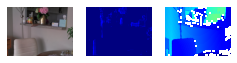

536/536 [==============================] - 869s 1s/step - batch: 267.5000 - size: 15.9963 - loss: 3.5985 - mae: 2.8762 - rmse: 4.7152 - abs_rel: 0.6830 - log10_mae: 0.3553 - log10_rmse: 0.4262 - val_loss: 1.3340 - val_mae: 2.8536 - val_rmse: 3.3914 - val_abs_rel: 0.6276 - val_log10_mae: 0.3279 - val_log10_rmse: 0.3581

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 1.1321 - mae: 2.5535 - rmse: 4.5079 - abs_rel: 0.5696 - log10_mae: 0.2788 - log10_rmse: 0.3570

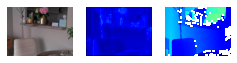

536/536 [==============================] - 513s 958ms/step - batch: 267.5000 - size: 15.9963 - loss: 1.1321 - mae: 2.5535 - rmse: 4.5079 - abs_rel: 0.5696 - log10_mae: 0.2788 - log10_rmse: 0.3570 - val_loss: 0.9638 - val_mae: 2.5389 - val_rmse: 3.1094 - val_abs_rel: 0.5258 - val_log10_mae: 0.2615 - val_log10_rmse: 0.2936

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.8809 - mae: 2.3713 - rmse: 4.3438 - abs_rel: 0.5301 - log10_mae: 0.2412 - log10_rmse: 0.3188

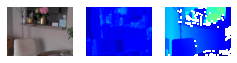

536/536 [==============================] - 513s 958ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.8809 - mae: 2.3713 - rmse: 4.3438 - abs_rel: 0.5301 - log10_mae: 0.2412 - log10_rmse: 0.3188 - val_loss: 0.7912 - val_mae: 2.4554 - val_rmse: 3.0319 - val_abs_rel: 0.5046 - val_log10_mae: 0.2458 - val_log10_rmse: 0.2782

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.7044 - mae: 2.2108 - rmse: 4.1693 - abs_rel: 0.5067 - log10_mae: 0.2099 - log10_rmse: 0.2819

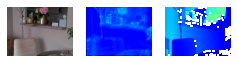

536/536 [==============================] - 513s 958ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.7044 - mae: 2.2108 - rmse: 4.1693 - abs_rel: 0.5067 - log10_mae: 0.2099 - log10_rmse: 0.2819 - val_loss: 0.6523 - val_mae: 2.2531 - val_rmse: 2.8402 - val_abs_rel: 0.4578 - val_log10_mae: 0.2105 - val_log10_rmse: 0.2428

Epoch 00005: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 5/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.6149 - mae: 2.1218 - rmse: 4.0556 - abs_rel: 0.4992 - log10_mae: 0.1952 - log10_rmse: 0.2634

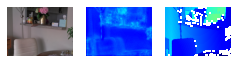

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.6149 - mae: 2.1218 - rmse: 4.0556 - abs_rel: 0.4992 - log10_mae: 0.1952 - log10_rmse: 0.2634 - val_loss: 0.5819 - val_mae: 2.1638 - val_rmse: 2.7545 - val_abs_rel: 0.4436 - val_log10_mae: 0.1961 - val_log10_rmse: 0.2286

Epoch 00006: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 6/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.5571 - mae: 2.0657 - rmse: 3.9757 - abs_rel: 0.4965 - log10_mae: 0.1865 - log10_rmse: 0.2521

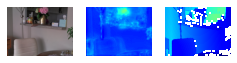

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.5571 - mae: 2.0657 - rmse: 3.9757 - abs_rel: 0.4965 - log10_mae: 0.1865 - log10_rmse: 0.2521 - val_loss: 0.5293 - val_mae: 2.0922 - val_rmse: 2.6817 - val_abs_rel: 0.4332 - val_log10_mae: 0.1856 - val_log10_rmse: 0.2180

Epoch 00007: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 7/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4908 - mae: 1.9833 - rmse: 3.8827 - abs_rel: 0.4890 - log10_mae: 0.1748 - log10_rmse: 0.2361

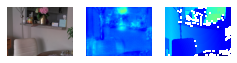

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4908 - mae: 1.9833 - rmse: 3.8827 - abs_rel: 0.4890 - log10_mae: 0.1748 - log10_rmse: 0.2361 - val_loss: 0.4984 - val_mae: 2.0663 - val_rmse: 2.6449 - val_abs_rel: 0.4273 - val_log10_mae: 0.1822 - val_log10_rmse: 0.2137

Epoch 00008: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 8/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.4339 - mae: 1.9043 - rmse: 3.7501 - abs_rel: 0.4763 - log10_mae: 0.1642 - log10_rmse: 0.2213

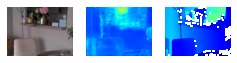

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.4339 - mae: 1.9043 - rmse: 3.7501 - abs_rel: 0.4763 - log10_mae: 0.1642 - log10_rmse: 0.2213 - val_loss: 0.4430 - val_mae: 1.9697 - val_rmse: 2.5390 - val_abs_rel: 0.4346 - val_log10_mae: 0.1684 - val_log10_rmse: 0.2001

Epoch 00009: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 9/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3988 - mae: 1.8540 - rmse: 3.6026 - abs_rel: 0.4719 - log10_mae: 0.1585 - log10_rmse: 0.2120

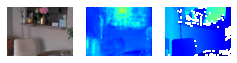

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3988 - mae: 1.8540 - rmse: 3.6026 - abs_rel: 0.4719 - log10_mae: 0.1585 - log10_rmse: 0.2120 - val_loss: 0.4156 - val_mae: 1.9839 - val_rmse: 2.5461 - val_abs_rel: 0.4274 - val_log10_mae: 0.1709 - val_log10_rmse: 0.2015

Epoch 00010: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 10/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3634 - mae: 1.7942 - rmse: 3.5219 - abs_rel: 0.4610 - log10_mae: 0.1516 - log10_rmse: 0.2026

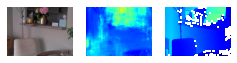

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3634 - mae: 1.7942 - rmse: 3.5219 - abs_rel: 0.4610 - log10_mae: 0.1516 - log10_rmse: 0.2026 - val_loss: 0.3835 - val_mae: 1.8904 - val_rmse: 2.4424 - val_abs_rel: 0.4374 - val_log10_mae: 0.1604 - val_log10_rmse: 0.1920

Epoch 00011: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 11/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3446 - mae: 1.7646 - rmse: 3.4556 - abs_rel: 0.4592 - log10_mae: 0.1488 - log10_rmse: 0.1980

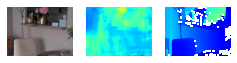

536/536 [==============================] - 514s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3446 - mae: 1.7646 - rmse: 3.4556 - abs_rel: 0.4592 - log10_mae: 0.1488 - log10_rmse: 0.1980 - val_loss: 0.3828 - val_mae: 1.8519 - val_rmse: 2.3801 - val_abs_rel: 0.5506 - val_log10_mae: 0.1555 - val_log10_rmse: 0.1876

Epoch 00012: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 12/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.3139 - mae: 1.6907 - rmse: 3.3511 - abs_rel: 0.4383 - log10_mae: 0.1408 - log10_rmse: 0.1872

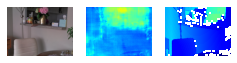

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.3139 - mae: 1.6907 - rmse: 3.3511 - abs_rel: 0.4383 - log10_mae: 0.1408 - log10_rmse: 0.1872 - val_loss: 0.3351 - val_mae: 1.7739 - val_rmse: 2.3298 - val_abs_rel: 0.4696 - val_log10_mae: 0.1458 - val_log10_rmse: 0.1782

Epoch 00013: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 13/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2909 - mae: 1.6244 - rmse: 3.2526 - abs_rel: 0.4181 - log10_mae: 0.1335 - log10_rmse: 0.1780

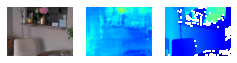

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2909 - mae: 1.6244 - rmse: 3.2526 - abs_rel: 0.4181 - log10_mae: 0.1335 - log10_rmse: 0.1780 - val_loss: 0.3215 - val_mae: 1.7885 - val_rmse: 2.3242 - val_abs_rel: 0.4622 - val_log10_mae: 0.1468 - val_log10_rmse: 0.1772

Epoch 00014: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 14/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2693 - mae: 1.5544 - rmse: 3.1412 - abs_rel: 0.3962 - log10_mae: 0.1268 - log10_rmse: 0.1690

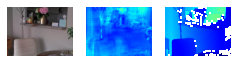

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2693 - mae: 1.5544 - rmse: 3.1412 - abs_rel: 0.3962 - log10_mae: 0.1268 - log10_rmse: 0.1690 - val_loss: 0.3132 - val_mae: 1.8053 - val_rmse: 2.3328 - val_abs_rel: 0.4286 - val_log10_mae: 0.1498 - val_log10_rmse: 0.1790

Epoch 00015: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 15/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2517 - mae: 1.5091 - rmse: 3.0570 - abs_rel: 0.3832 - log10_mae: 0.1219 - log10_rmse: 0.1627

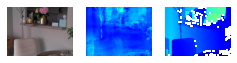

536/536 [==============================] - 514s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2517 - mae: 1.5091 - rmse: 3.0570 - abs_rel: 0.3832 - log10_mae: 0.1219 - log10_rmse: 0.1627 - val_loss: 0.3551 - val_mae: 1.8584 - val_rmse: 2.4357 - val_abs_rel: 0.4162 - val_log10_mae: 0.1550 - val_log10_rmse: 0.1862

Epoch 00016: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 16/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2373 - mae: 1.4650 - rmse: 2.9765 - abs_rel: 0.3710 - log10_mae: 0.1173 - log10_rmse: 0.1569

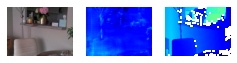

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2373 - mae: 1.4650 - rmse: 2.9765 - abs_rel: 0.3710 - log10_mae: 0.1173 - log10_rmse: 0.1569 - val_loss: 0.3816 - val_mae: 1.9991 - val_rmse: 2.5453 - val_abs_rel: 0.4218 - val_log10_mae: 0.1764 - val_log10_rmse: 0.2061

Epoch 00017: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 17/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2245 - mae: 1.4316 - rmse: 2.9240 - abs_rel: 0.3637 - log10_mae: 0.1144 - log10_rmse: 0.1532

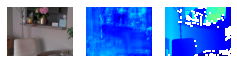

536/536 [==============================] - 514s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2245 - mae: 1.4316 - rmse: 2.9240 - abs_rel: 0.3637 - log10_mae: 0.1144 - log10_rmse: 0.1532 - val_loss: 0.3290 - val_mae: 1.8925 - val_rmse: 2.4374 - val_abs_rel: 0.4232 - val_log10_mae: 0.1620 - val_log10_rmse: 0.1922

Epoch 00018: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 18/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2121 - mae: 1.3921 - rmse: 2.8871 - abs_rel: 0.3510 - log10_mae: 0.1103 - log10_rmse: 0.1482

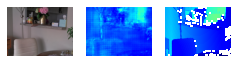

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2121 - mae: 1.3921 - rmse: 2.8871 - abs_rel: 0.3510 - log10_mae: 0.1103 - log10_rmse: 0.1482 - val_loss: 0.2905 - val_mae: 1.8118 - val_rmse: 2.3253 - val_abs_rel: 0.4111 - val_log10_mae: 0.1518 - val_log10_rmse: 0.1793

Epoch 00019: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 19/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.2053 - mae: 1.3672 - rmse: 2.8253 - abs_rel: 0.3438 - log10_mae: 0.1079 - log10_rmse: 0.1456

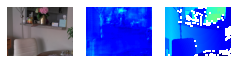

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.2053 - mae: 1.3672 - rmse: 2.8253 - abs_rel: 0.3438 - log10_mae: 0.1079 - log10_rmse: 0.1456 - val_loss: 0.2915 - val_mae: 1.8055 - val_rmse: 2.3013 - val_abs_rel: 0.4092 - val_log10_mae: 0.1535 - val_log10_rmse: 0.1806

Epoch 00020: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 20/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1914 - mae: 1.3261 - rmse: 2.7927 - abs_rel: 0.3326 - log10_mae: 0.1038 - log10_rmse: 0.1403

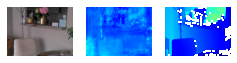

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1914 - mae: 1.3261 - rmse: 2.7927 - abs_rel: 0.3326 - log10_mae: 0.1038 - log10_rmse: 0.1403 - val_loss: 0.3031 - val_mae: 1.8647 - val_rmse: 2.3904 - val_abs_rel: 0.4219 - val_log10_mae: 0.1564 - val_log10_rmse: 0.1842

Epoch 00021: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 21/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1803 - mae: 1.2956 - rmse: 2.7138 - abs_rel: 0.3235 - log10_mae: 0.1008 - log10_rmse: 0.1358

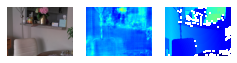

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1803 - mae: 1.2956 - rmse: 2.7138 - abs_rel: 0.3235 - log10_mae: 0.1008 - log10_rmse: 0.1358 - val_loss: 0.2581 - val_mae: 1.7440 - val_rmse: 2.2641 - val_abs_rel: 0.4329 - val_log10_mae: 0.1432 - val_log10_rmse: 0.1728

Epoch 00022: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 22/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1755 - mae: 1.2791 - rmse: 2.6814 - abs_rel: 0.3213 - log10_mae: 0.0996 - log10_rmse: 0.1345

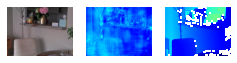

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1755 - mae: 1.2791 - rmse: 2.6814 - abs_rel: 0.3213 - log10_mae: 0.0996 - log10_rmse: 0.1345 - val_loss: 0.2852 - val_mae: 1.8478 - val_rmse: 2.3922 - val_abs_rel: 0.4546 - val_log10_mae: 0.1539 - val_log10_rmse: 0.1836

Epoch 00023: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 23/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1682 - mae: 1.2495 - rmse: 2.6018 - abs_rel: 0.3132 - log10_mae: 0.0968 - log10_rmse: 0.1306

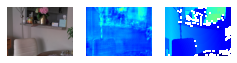

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1682 - mae: 1.2495 - rmse: 2.6018 - abs_rel: 0.3132 - log10_mae: 0.0968 - log10_rmse: 0.1306 - val_loss: 0.2888 - val_mae: 1.8556 - val_rmse: 2.3936 - val_abs_rel: 0.4124 - val_log10_mae: 0.1561 - val_log10_rmse: 0.1846

Epoch 00024: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 24/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1638 - mae: 1.2389 - rmse: 2.6137 - abs_rel: 0.3111 - log10_mae: 0.0958 - log10_rmse: 0.1298

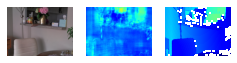

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1638 - mae: 1.2389 - rmse: 2.6137 - abs_rel: 0.3111 - log10_mae: 0.0958 - log10_rmse: 0.1298 - val_loss: 0.2840 - val_mae: 1.8195 - val_rmse: 2.3283 - val_abs_rel: 0.4283 - val_log10_mae: 0.1523 - val_log10_rmse: 0.1811

Epoch 00025: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 25/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1481 - mae: 1.1823 - rmse: 2.4882 - abs_rel: 0.2931 - log10_mae: 0.0904 - log10_rmse: 0.1224

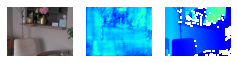

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1481 - mae: 1.1823 - rmse: 2.4882 - abs_rel: 0.2931 - log10_mae: 0.0904 - log10_rmse: 0.1224 - val_loss: 0.2618 - val_mae: 1.8139 - val_rmse: 2.2968 - val_abs_rel: 0.4995 - val_log10_mae: 0.1515 - val_log10_rmse: 0.1802

Epoch 00026: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 26/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1482 - mae: 1.1786 - rmse: 2.5178 - abs_rel: 0.2924 - log10_mae: 0.0900 - log10_rmse: 0.1227

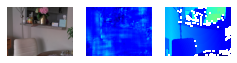

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1482 - mae: 1.1786 - rmse: 2.5178 - abs_rel: 0.2924 - log10_mae: 0.0900 - log10_rmse: 0.1227 - val_loss: 0.3073 - val_mae: 1.8735 - val_rmse: 2.4113 - val_abs_rel: 0.4298 - val_log10_mae: 0.1634 - val_log10_rmse: 0.1941

Epoch 00027: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 27/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1427 - mae: 1.1577 - rmse: 2.4519 - abs_rel: 0.2877 - log10_mae: 0.0884 - log10_rmse: 0.1197

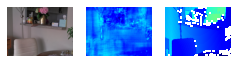

536/536 [==============================] - 514s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1427 - mae: 1.1577 - rmse: 2.4519 - abs_rel: 0.2877 - log10_mae: 0.0884 - log10_rmse: 0.1197 - val_loss: 0.2797 - val_mae: 1.8531 - val_rmse: 2.3909 - val_abs_rel: 0.4129 - val_log10_mae: 0.1578 - val_log10_rmse: 0.1868

Epoch 00028: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 28/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1384 - mae: 1.1483 - rmse: 2.4139 - abs_rel: 0.2843 - log10_mae: 0.0874 - log10_rmse: 0.1182

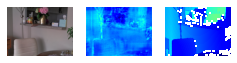

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1384 - mae: 1.1483 - rmse: 2.4139 - abs_rel: 0.2843 - log10_mae: 0.0874 - log10_rmse: 0.1182 - val_loss: 0.2950 - val_mae: 1.8859 - val_rmse: 2.4205 - val_abs_rel: 0.4219 - val_log10_mae: 0.1606 - val_log10_rmse: 0.1889

Epoch 00029: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 29/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1324 - mae: 1.1233 - rmse: 2.3866 - abs_rel: 0.2776 - log10_mae: 0.0852 - log10_rmse: 0.1155

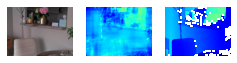

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1324 - mae: 1.1233 - rmse: 2.3866 - abs_rel: 0.2776 - log10_mae: 0.0852 - log10_rmse: 0.1155 - val_loss: 0.2397 - val_mae: 1.7516 - val_rmse: 2.2761 - val_abs_rel: 0.4696 - val_log10_mae: 0.1452 - val_log10_rmse: 0.1771

Epoch 00030: LearningRateScheduler reducing learning rate to 3.33333324912625e-05.
Epoch 30/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1097 - mae: 1.0301 - rmse: 2.2604 - abs_rel: 0.2464 - log10_mae: 0.0762 - log10_rmse: 0.1052

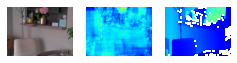

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1097 - mae: 1.0301 - rmse: 2.2604 - abs_rel: 0.2464 - log10_mae: 0.0762 - log10_rmse: 0.1052 - val_loss: 0.2322 - val_mae: 1.7440 - val_rmse: 2.2523 - val_abs_rel: 0.4585 - val_log10_mae: 0.1439 - val_log10_rmse: 0.1742

Epoch 00031: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 31/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1095 - mae: 1.0321 - rmse: 2.2693 - abs_rel: 0.2440 - log10_mae: 0.0759 - log10_rmse: 0.1051

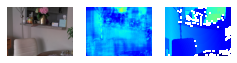

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1095 - mae: 1.0321 - rmse: 2.2693 - abs_rel: 0.2440 - log10_mae: 0.0759 - log10_rmse: 0.1051 - val_loss: 0.2609 - val_mae: 1.8116 - val_rmse: 2.3290 - val_abs_rel: 0.4302 - val_log10_mae: 0.1518 - val_log10_rmse: 0.1806

Epoch 00032: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 32/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1063 - mae: 1.0153 - rmse: 2.2221 - abs_rel: 0.2398 - log10_mae: 0.0746 - log10_rmse: 0.1031

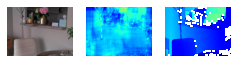

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1063 - mae: 1.0153 - rmse: 2.2221 - abs_rel: 0.2398 - log10_mae: 0.0746 - log10_rmse: 0.1031 - val_loss: 0.2374 - val_mae: 1.7586 - val_rmse: 2.2487 - val_abs_rel: 0.4449 - val_log10_mae: 0.1465 - val_log10_rmse: 0.1751

Epoch 00033: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 33/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1028 - mae: 0.9985 - rmse: 2.2239 - abs_rel: 0.2331 - log10_mae: 0.0729 - log10_rmse: 0.1015

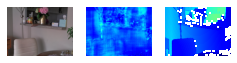

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1028 - mae: 0.9985 - rmse: 2.2239 - abs_rel: 0.2331 - log10_mae: 0.0729 - log10_rmse: 0.1015 - val_loss: 0.2513 - val_mae: 1.7810 - val_rmse: 2.2920 - val_abs_rel: 0.4164 - val_log10_mae: 0.1501 - val_log10_rmse: 0.1793

Epoch 00034: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 34/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1041 - mae: 1.0053 - rmse: 2.2280 - abs_rel: 0.2356 - log10_mae: 0.0736 - log10_rmse: 0.1023

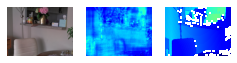

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1041 - mae: 1.0053 - rmse: 2.2280 - abs_rel: 0.2356 - log10_mae: 0.0736 - log10_rmse: 0.1023 - val_loss: 0.2333 - val_mae: 1.7435 - val_rmse: 2.2616 - val_abs_rel: 0.4409 - val_log10_mae: 0.1450 - val_log10_rmse: 0.1751

Epoch 00035: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 35/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.1004 - mae: 0.9837 - rmse: 2.2025 - abs_rel: 0.2297 - log10_mae: 0.0718 - log10_rmse: 0.0999

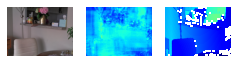

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.1004 - mae: 0.9837 - rmse: 2.2025 - abs_rel: 0.2297 - log10_mae: 0.0718 - log10_rmse: 0.0999 - val_loss: 0.2432 - val_mae: 1.7838 - val_rmse: 2.3019 - val_abs_rel: 0.4449 - val_log10_mae: 0.1486 - val_log10_rmse: 0.1779

Epoch 00036: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 36/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0988 - mae: 0.9779 - rmse: 2.1778 - abs_rel: 0.2255 - log10_mae: 0.0707 - log10_rmse: 0.0988

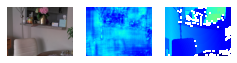

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0988 - mae: 0.9779 - rmse: 2.1778 - abs_rel: 0.2255 - log10_mae: 0.0707 - log10_rmse: 0.0988 - val_loss: 0.2345 - val_mae: 1.7525 - val_rmse: 2.2569 - val_abs_rel: 0.4317 - val_log10_mae: 0.1460 - val_log10_rmse: 0.1752

Epoch 00037: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 37/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0975 - mae: 0.9732 - rmse: 2.1577 - abs_rel: 0.2262 - log10_mae: 0.0706 - log10_rmse: 0.0985

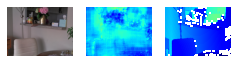

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0975 - mae: 0.9732 - rmse: 2.1577 - abs_rel: 0.2262 - log10_mae: 0.0706 - log10_rmse: 0.0985 - val_loss: 0.2474 - val_mae: 1.7874 - val_rmse: 2.3102 - val_abs_rel: 0.4374 - val_log10_mae: 0.1488 - val_log10_rmse: 0.1786

Epoch 00038: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 38/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0954 - mae: 0.9640 - rmse: 2.1459 - abs_rel: 0.2232 - log10_mae: 0.0698 - log10_rmse: 0.0974

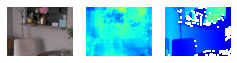

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0954 - mae: 0.9640 - rmse: 2.1459 - abs_rel: 0.2232 - log10_mae: 0.0698 - log10_rmse: 0.0974 - val_loss: 0.2238 - val_mae: 1.7409 - val_rmse: 2.2493 - val_abs_rel: 0.5090 - val_log10_mae: 0.1443 - val_log10_rmse: 0.1757

Epoch 00039: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 39/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0948 - mae: 0.9625 - rmse: 2.1434 - abs_rel: 0.2234 - log10_mae: 0.0696 - log10_rmse: 0.0970

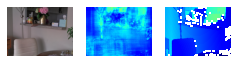

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0948 - mae: 0.9625 - rmse: 2.1434 - abs_rel: 0.2234 - log10_mae: 0.0696 - log10_rmse: 0.0970 - val_loss: 0.2579 - val_mae: 1.8093 - val_rmse: 2.3406 - val_abs_rel: 0.4327 - val_log10_mae: 0.1521 - val_log10_rmse: 0.1818

Epoch 00040: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 40/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0946 - mae: 0.9574 - rmse: 2.1254 - abs_rel: 0.2231 - log10_mae: 0.0694 - log10_rmse: 0.0968

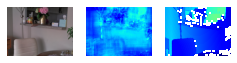

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0946 - mae: 0.9574 - rmse: 2.1254 - abs_rel: 0.2231 - log10_mae: 0.0694 - log10_rmse: 0.0968 - val_loss: 0.2398 - val_mae: 1.7579 - val_rmse: 2.2725 - val_abs_rel: 0.4280 - val_log10_mae: 0.1457 - val_log10_rmse: 0.1749

Epoch 00041: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 41/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0930 - mae: 0.9513 - rmse: 2.0999 - abs_rel: 0.2230 - log10_mae: 0.0693 - log10_rmse: 0.0960

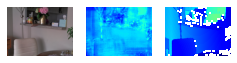

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0930 - mae: 0.9513 - rmse: 2.0999 - abs_rel: 0.2230 - log10_mae: 0.0693 - log10_rmse: 0.0960 - val_loss: 0.2280 - val_mae: 1.7406 - val_rmse: 2.2585 - val_abs_rel: 0.4572 - val_log10_mae: 0.1436 - val_log10_rmse: 0.1734

Epoch 00042: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 42/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0907 - mae: 0.9397 - rmse: 2.1033 - abs_rel: 0.2188 - log10_mae: 0.0679 - log10_rmse: 0.0951

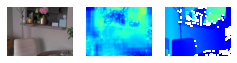

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0907 - mae: 0.9397 - rmse: 2.1033 - abs_rel: 0.2188 - log10_mae: 0.0679 - log10_rmse: 0.0951 - val_loss: 0.2199 - val_mae: 1.7303 - val_rmse: 2.2570 - val_abs_rel: 0.4601 - val_log10_mae: 0.1428 - val_log10_rmse: 0.1737

Epoch 00043: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 43/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0921 - mae: 0.9480 - rmse: 2.0936 - abs_rel: 0.2231 - log10_mae: 0.0692 - log10_rmse: 0.0959

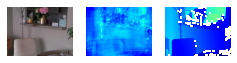

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0921 - mae: 0.9480 - rmse: 2.0936 - abs_rel: 0.2231 - log10_mae: 0.0692 - log10_rmse: 0.0959 - val_loss: 0.2626 - val_mae: 1.8078 - val_rmse: 2.3243 - val_abs_rel: 0.4224 - val_log10_mae: 0.1511 - val_log10_rmse: 0.1804

Epoch 00044: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 44/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0898 - mae: 0.9372 - rmse: 2.0675 - abs_rel: 0.2182 - log10_mae: 0.0678 - log10_rmse: 0.0944

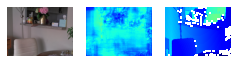

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0898 - mae: 0.9372 - rmse: 2.0675 - abs_rel: 0.2182 - log10_mae: 0.0678 - log10_rmse: 0.0944 - val_loss: 0.2286 - val_mae: 1.7587 - val_rmse: 2.2650 - val_abs_rel: 0.4776 - val_log10_mae: 0.1463 - val_log10_rmse: 0.1769

Epoch 00045: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 45/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0895 - mae: 0.9366 - rmse: 2.0814 - abs_rel: 0.2185 - log10_mae: 0.0679 - log10_rmse: 0.0947

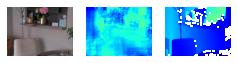

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0895 - mae: 0.9366 - rmse: 2.0814 - abs_rel: 0.2185 - log10_mae: 0.0679 - log10_rmse: 0.0947 - val_loss: 0.2215 - val_mae: 1.7265 - val_rmse: 2.2442 - val_abs_rel: 0.4540 - val_log10_mae: 0.1425 - val_log10_rmse: 0.1730

Epoch 00046: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 46/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0875 - mae: 0.9227 - rmse: 2.0442 - abs_rel: 0.2159 - log10_mae: 0.0670 - log10_rmse: 0.0938

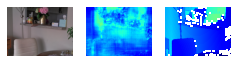

536/536 [==============================] - 515s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0875 - mae: 0.9227 - rmse: 2.0442 - abs_rel: 0.2159 - log10_mae: 0.0670 - log10_rmse: 0.0938 - val_loss: 0.2521 - val_mae: 1.8002 - val_rmse: 2.3253 - val_abs_rel: 0.4205 - val_log10_mae: 0.1527 - val_log10_rmse: 0.1824

Epoch 00047: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 47/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0859 - mae: 0.9199 - rmse: 2.0479 - abs_rel: 0.2155 - log10_mae: 0.0666 - log10_rmse: 0.0927

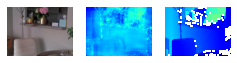

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0859 - mae: 0.9199 - rmse: 2.0479 - abs_rel: 0.2155 - log10_mae: 0.0666 - log10_rmse: 0.0927 - val_loss: 0.2491 - val_mae: 1.7863 - val_rmse: 2.3185 - val_abs_rel: 0.4277 - val_log10_mae: 0.1472 - val_log10_rmse: 0.1768

Epoch 00048: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 48/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0849 - mae: 0.9127 - rmse: 2.0084 - abs_rel: 0.2137 - log10_mae: 0.0660 - log10_rmse: 0.0919

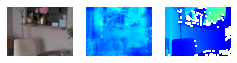

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0849 - mae: 0.9127 - rmse: 2.0084 - abs_rel: 0.2137 - log10_mae: 0.0660 - log10_rmse: 0.0919 - val_loss: 0.2435 - val_mae: 1.7836 - val_rmse: 2.2886 - val_abs_rel: 0.4228 - val_log10_mae: 0.1495 - val_log10_rmse: 0.1779

Epoch 00049: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 49/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0843 - mae: 0.9087 - rmse: 2.0112 - abs_rel: 0.2121 - log10_mae: 0.0656 - log10_rmse: 0.0918

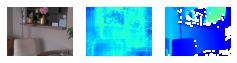

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0843 - mae: 0.9087 - rmse: 2.0112 - abs_rel: 0.2121 - log10_mae: 0.0656 - log10_rmse: 0.0918 - val_loss: 0.2366 - val_mae: 1.7788 - val_rmse: 2.2848 - val_abs_rel: 0.4813 - val_log10_mae: 0.1476 - val_log10_rmse: 0.1778

Epoch 00050: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 50/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0840 - mae: 0.9112 - rmse: 2.0244 - abs_rel: 0.2131 - log10_mae: 0.0657 - log10_rmse: 0.0915

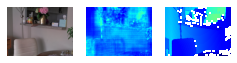

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0840 - mae: 0.9112 - rmse: 2.0244 - abs_rel: 0.2131 - log10_mae: 0.0657 - log10_rmse: 0.0915 - val_loss: 0.2453 - val_mae: 1.7790 - val_rmse: 2.3058 - val_abs_rel: 0.4201 - val_log10_mae: 0.1490 - val_log10_rmse: 0.1786

Epoch 00051: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 51/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0824 - mae: 0.8965 - rmse: 2.0012 - abs_rel: 0.2100 - log10_mae: 0.0648 - log10_rmse: 0.0908

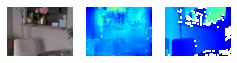

536/536 [==============================] - 519s 968ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0824 - mae: 0.8965 - rmse: 2.0012 - abs_rel: 0.2100 - log10_mae: 0.0648 - log10_rmse: 0.0908 - val_loss: 0.2589 - val_mae: 1.8155 - val_rmse: 2.3430 - val_abs_rel: 0.4291 - val_log10_mae: 0.1516 - val_log10_rmse: 0.1807

Epoch 00052: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 52/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0822 - mae: 0.8966 - rmse: 1.9951 - abs_rel: 0.2102 - log10_mae: 0.0648 - log10_rmse: 0.0906

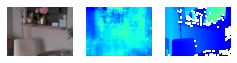

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0822 - mae: 0.8966 - rmse: 1.9951 - abs_rel: 0.2102 - log10_mae: 0.0648 - log10_rmse: 0.0906 - val_loss: 0.2167 - val_mae: 1.7028 - val_rmse: 2.2089 - val_abs_rel: 0.4365 - val_log10_mae: 0.1397 - val_log10_rmse: 0.1694

Epoch 00053: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 53/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0806 - mae: 0.8912 - rmse: 1.9757 - abs_rel: 0.2095 - log10_mae: 0.0644 - log10_rmse: 0.0901

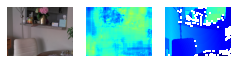

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0806 - mae: 0.8912 - rmse: 1.9757 - abs_rel: 0.2095 - log10_mae: 0.0644 - log10_rmse: 0.0901 - val_loss: 0.2361 - val_mae: 1.8590 - val_rmse: 2.3905 - val_abs_rel: 0.6224 - val_log10_mae: 0.1561 - val_log10_rmse: 0.1907

Epoch 00054: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 54/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0819 - mae: 0.8937 - rmse: 1.9792 - abs_rel: 0.2117 - log10_mae: 0.0649 - log10_rmse: 0.0905

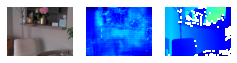

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0819 - mae: 0.8937 - rmse: 1.9792 - abs_rel: 0.2117 - log10_mae: 0.0649 - log10_rmse: 0.0905 - val_loss: 0.2886 - val_mae: 1.8799 - val_rmse: 2.4151 - val_abs_rel: 0.4203 - val_log10_mae: 0.1651 - val_log10_rmse: 0.1960

Epoch 00055: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 55/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0785 - mae: 0.8799 - rmse: 1.9653 - abs_rel: 0.2064 - log10_mae: 0.0633 - log10_rmse: 0.0886

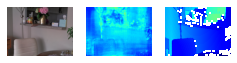

536/536 [==============================] - 514s 960ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0785 - mae: 0.8799 - rmse: 1.9653 - abs_rel: 0.2064 - log10_mae: 0.0633 - log10_rmse: 0.0886 - val_loss: 0.2388 - val_mae: 1.7645 - val_rmse: 2.2961 - val_abs_rel: 0.4385 - val_log10_mae: 0.1455 - val_log10_rmse: 0.1752

Epoch 00056: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 56/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0791 - mae: 0.8818 - rmse: 1.9781 - abs_rel: 0.2060 - log10_mae: 0.0633 - log10_rmse: 0.0890

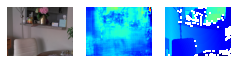

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0791 - mae: 0.8818 - rmse: 1.9781 - abs_rel: 0.2060 - log10_mae: 0.0633 - log10_rmse: 0.0890 - val_loss: 0.2352 - val_mae: 1.7680 - val_rmse: 2.4648 - val_abs_rel: 0.4455 - val_log10_mae: 0.1454 - val_log10_rmse: 0.1774

Epoch 00057: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 57/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0789 - mae: 0.8823 - rmse: 1.9696 - abs_rel: 0.2067 - log10_mae: 0.0635 - log10_rmse: 0.0890

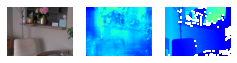

536/536 [==============================] - 514s 959ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0789 - mae: 0.8823 - rmse: 1.9696 - abs_rel: 0.2067 - log10_mae: 0.0635 - log10_rmse: 0.0890 - val_loss: 0.2427 - val_mae: 1.7756 - val_rmse: 2.3029 - val_abs_rel: 0.4270 - val_log10_mae: 0.1464 - val_log10_rmse: 0.1761

Epoch 00058: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 58/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0765 - mae: 0.8653 - rmse: 1.9213 - abs_rel: 0.2044 - log10_mae: 0.0625 - log10_rmse: 0.0873

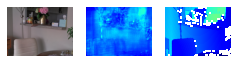

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0765 - mae: 0.8653 - rmse: 1.9213 - abs_rel: 0.2044 - log10_mae: 0.0625 - log10_rmse: 0.0873 - val_loss: 0.2650 - val_mae: 1.8301 - val_rmse: 2.3534 - val_abs_rel: 0.4141 - val_log10_mae: 0.1541 - val_log10_rmse: 0.1826

Epoch 00059: LearningRateScheduler reducing learning rate to 3.333333370392211e-05.
Epoch 59/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0746 - mae: 0.8610 - rmse: 1.9086 - abs_rel: 0.2031 - log10_mae: 0.0620 - log10_rmse: 0.0863

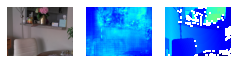

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0746 - mae: 0.8610 - rmse: 1.9086 - abs_rel: 0.2031 - log10_mae: 0.0620 - log10_rmse: 0.0863 - val_loss: 0.2673 - val_mae: 1.8228 - val_rmse: 2.3386 - val_abs_rel: 0.4149 - val_log10_mae: 0.1528 - val_log10_rmse: 0.1818

Epoch 00060: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 60/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0688 - mae: 0.8220 - rmse: 1.8663 - abs_rel: 0.1907 - log10_mae: 0.0583 - log10_rmse: 0.0829

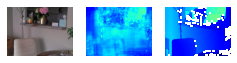

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0688 - mae: 0.8220 - rmse: 1.8663 - abs_rel: 0.1907 - log10_mae: 0.0583 - log10_rmse: 0.0829 - val_loss: 0.2418 - val_mae: 1.7814 - val_rmse: 2.3041 - val_abs_rel: 0.4312 - val_log10_mae: 0.1485 - val_log10_rmse: 0.1785

Epoch 00061: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 61/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0696 - mae: 0.8287 - rmse: 1.8876 - abs_rel: 0.1913 - log10_mae: 0.0586 - log10_rmse: 0.0836

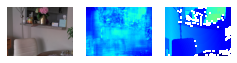

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0696 - mae: 0.8287 - rmse: 1.8876 - abs_rel: 0.1913 - log10_mae: 0.0586 - log10_rmse: 0.0836 - val_loss: 0.2377 - val_mae: 1.7669 - val_rmse: 2.2762 - val_abs_rel: 0.4241 - val_log10_mae: 0.1479 - val_log10_rmse: 0.1776

Epoch 00062: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 62/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0675 - mae: 0.8113 - rmse: 1.8509 - abs_rel: 0.1892 - log10_mae: 0.0577 - log10_rmse: 0.0821

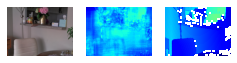

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0675 - mae: 0.8113 - rmse: 1.8509 - abs_rel: 0.1892 - log10_mae: 0.0577 - log10_rmse: 0.0821 - val_loss: 0.2258 - val_mae: 1.7336 - val_rmse: 2.2517 - val_abs_rel: 0.4310 - val_log10_mae: 0.1434 - val_log10_rmse: 0.1740

Epoch 00063: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 63/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0688 - mae: 0.8284 - rmse: 1.9012 - abs_rel: 0.1899 - log10_mae: 0.0582 - log10_rmse: 0.0830

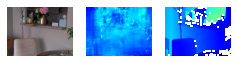

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0688 - mae: 0.8284 - rmse: 1.9012 - abs_rel: 0.1899 - log10_mae: 0.0582 - log10_rmse: 0.0830 - val_loss: 0.2480 - val_mae: 1.7922 - val_rmse: 2.3134 - val_abs_rel: 0.4204 - val_log10_mae: 0.1495 - val_log10_rmse: 0.1785

Epoch 00064: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 64/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0681 - mae: 0.8157 - rmse: 1.8502 - abs_rel: 0.1881 - log10_mae: 0.0576 - log10_rmse: 0.0819

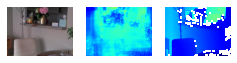

536/536 [==============================] - 515s 961ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0681 - mae: 0.8157 - rmse: 1.8502 - abs_rel: 0.1881 - log10_mae: 0.0576 - log10_rmse: 0.0819 - val_loss: 0.2276 - val_mae: 1.7532 - val_rmse: 2.2753 - val_abs_rel: 0.4565 - val_log10_mae: 0.1453 - val_log10_rmse: 0.1762

Epoch 00065: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 65/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0690 - mae: 0.8287 - rmse: 1.8935 - abs_rel: 0.1909 - log10_mae: 0.0586 - log10_rmse: 0.0834

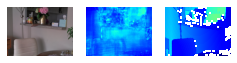

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0690 - mae: 0.8287 - rmse: 1.8935 - abs_rel: 0.1909 - log10_mae: 0.0586 - log10_rmse: 0.0834 - val_loss: 0.2527 - val_mae: 1.8044 - val_rmse: 2.3241 - val_abs_rel: 0.4166 - val_log10_mae: 0.1517 - val_log10_rmse: 0.1809

Epoch 00066: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 66/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0667 - mae: 0.8094 - rmse: 1.8459 - abs_rel: 0.1868 - log10_mae: 0.0570 - log10_rmse: 0.0814

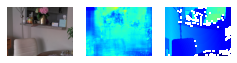

536/536 [==============================] - 517s 964ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0667 - mae: 0.8094 - rmse: 1.8459 - abs_rel: 0.1868 - log10_mae: 0.0570 - log10_rmse: 0.0814 - val_loss: 0.2197 - val_mae: 1.7374 - val_rmse: 2.2458 - val_abs_rel: 0.4673 - val_log10_mae: 0.1430 - val_log10_rmse: 0.1738

Epoch 00067: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 67/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0685 - mae: 0.8214 - rmse: 1.8628 - abs_rel: 0.1909 - log10_mae: 0.0584 - log10_rmse: 0.0828

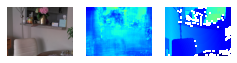

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0685 - mae: 0.8214 - rmse: 1.8628 - abs_rel: 0.1909 - log10_mae: 0.0584 - log10_rmse: 0.0828 - val_loss: 0.2396 - val_mae: 1.7696 - val_rmse: 2.2883 - val_abs_rel: 0.4236 - val_log10_mae: 0.1467 - val_log10_rmse: 0.1760

Epoch 00068: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 68/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0665 - mae: 0.8100 - rmse: 1.8489 - abs_rel: 0.1880 - log10_mae: 0.0574 - log10_rmse: 0.0816

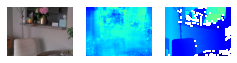

536/536 [==============================] - 516s 963ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0665 - mae: 0.8100 - rmse: 1.8489 - abs_rel: 0.1880 - log10_mae: 0.0574 - log10_rmse: 0.0816 - val_loss: 0.2239 - val_mae: 1.7384 - val_rmse: 2.2505 - val_abs_rel: 0.4616 - val_log10_mae: 0.1431 - val_log10_rmse: 0.1733

Epoch 00069: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 69/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0665 - mae: 0.8093 - rmse: 1.8424 - abs_rel: 0.1875 - log10_mae: 0.0573 - log10_rmse: 0.0815

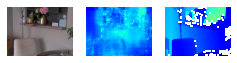

536/536 [==============================] - 516s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0665 - mae: 0.8093 - rmse: 1.8424 - abs_rel: 0.1875 - log10_mae: 0.0573 - log10_rmse: 0.0815 - val_loss: 0.2471 - val_mae: 1.7873 - val_rmse: 2.3090 - val_abs_rel: 0.4211 - val_log10_mae: 0.1490 - val_log10_rmse: 0.1784

Epoch 00070: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 70/100
536/536 [==============================] - ETA: 0s - batch: 267.5000 - size: 15.9963 - loss: 0.0672 - mae: 0.8152 - rmse: 1.8518 - abs_rel: 0.1888 - log10_mae: 0.0577 - log10_rmse: 0.0820

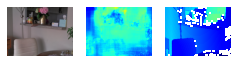

536/536 [==============================] - 515s 962ms/step - batch: 267.5000 - size: 15.9963 - loss: 0.0672 - mae: 0.8152 - rmse: 1.8518 - abs_rel: 0.1888 - log10_mae: 0.0577 - log10_rmse: 0.0820 - val_loss: 0.2157 - val_mae: 1.7434 - val_rmse: 2.2515 - val_abs_rel: 0.5014 - val_log10_mae: 0.1449 - val_log10_rmse: 0.1767

Epoch 00071: LearningRateScheduler reducing learning rate to 1.1111111234640703e-05.
Epoch 71/100
163/536 [========>.....................] - ETA: 5:55 - batch: 81.0000 - size: 16.0000 - loss: 0.0650 - mae: 0.7841 - rmse: 1.7781 - abs_rel: 0.1896 - log10_mae: 0.0570 - log10_rmse: 0.0811

In [ ]:
history = run_epochs(100, 30)

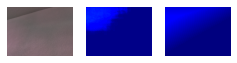

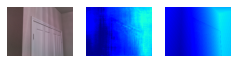

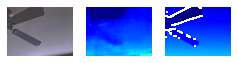

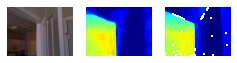

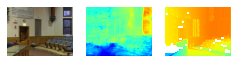

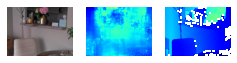

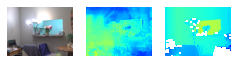

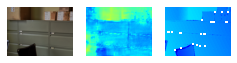

In [16]:
display_samples()

In [45]:
val_pred = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])
np.save("output/val_pred_" + run_name, val_pred)

In [18]:
model.evaluate([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask], [val_depth])

[0.22482249202636573, 1.6667796, 2.2751832, 0.4303017, 0.13830023, 0.1712138]

In [19]:
[m.name for m in model.metrics]

['mae', 'rmse', 'abs_rel', 'log10_mae', 'log10_rmse']

## Numpy Metrics

In [24]:
ln_log10 = 2.3025

def np_mae(y_true, y_pred, mask):
    return np.sum(np.abs(y_true - y_pred)) / np.count_nonzero(mask)
def np_rmse(y_true, y_pred, mask):
    return np.sqrt(np.sum(np.square(y_true - y_pred)) / np.count_nonzero(mask))
def np_abs_rel(y_true, y_pred, mask):
    return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)
def np_log10_mae(y_true, y_pred, mask):
    return np.sum(np.abs((np.log1p(y_true) / ln_log10) - (np.log1p(y_pred) / ln_log10))) / np.count_nonzero(mask)
def np_log10_rmse(y_true, y_pred, mask):
    return np.sqrt(np.sum(np.square((np.log1p(y_true) / ln_log10) - (np.log1p(y_pred) / ln_log10))) / np.count_nonzero(mask))
metrics = [np_mae, np_rmse, np_abs_rel, np_log10_mae, np_log10_rmse]

### Interpolation baseline

In [41]:
for metric in metrics:
    print(metric(val_depth * val_depth_mask, val_depth_scan * val_depth_mask, val_depth_mask))

0.5882732804061788
1.5649141431151479


<ipython-input-24-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.17319070655621227
0.04642555026878254
0.09667694710068131


### No lidar baseline

In [42]:
predictions = model.predict([val_rgb, val_depth_scan, val_depth_mask_scan, val_depth, val_depth_mask])
for metric in metrics:
    print(metric(val_depth * val_depth_mask, predictions * val_depth_mask, val_depth_mask))

1.7850146042091557
3.1460106563886194


<ipython-input-24-3423cf76e186>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.nan_to_num(np.abs(y_true - y_pred) / y_true)) / np.count_nonzero(mask)


0.45461612431650633
0.14662676982915293
0.201457545189891
